In [ ]:
import numpy as np
import pandas as pd
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [ ]:
!wget "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

--2023-08-21 04:21:09--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 173.222.197.27, 2600:1406:3c00:588::317f, 2600:1406:3c00:582::317f
Connecting to download.microsoft.com (download.microsoft.com)|173.222.197.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  56.5MB/s    in 13s     

2023-08-21 04:21:23 (59.3 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
!unzip /content/kagglecatsanddogs_5340.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [ ]:
mainfile = '/content/PetImages'
mainfile_dogs = os.path.join(mainfile, 'Dog')
mainfile_cats = os.path.join(mainfile, 'Cat')

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(mainfile_dogs))} images of dogs.")
print(f"There are {len(os.listdir(mainfile_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


In [ ]:
root_dir = '/content/Dataset'

def create_train_val_dirs(root_path):
  os.makedirs(root_path, 493 )
  train_dir = os.path.join(root_path, 'training')
  os.makedirs(train_dir, 493 )
  validation_dir = os.path.join(root_path, 'validation')
  os.makedirs(validation_dir, 493)
  train_cats_dir = os.path.join(train_dir, 'cats')
  os.makedirs(train_cats_dir, 493)
  train_dogs_dir = os.path.join(train_dir, 'dogs')
  os.makedirs(train_dogs_dir, 493)
  validation_cats_dir = os.path.join(validation_dir, 'cats')
  os.makedirs(validation_cats_dir, 493)
  validation_dogs_dir = os.path.join(validation_dir, 'dogs')
  os.makedirs(validation_dogs_dir, 493)

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  length = len([name for name in os.listdir(SOURCE_DIR)])
  newlength = int(length*SPLIT_SIZE)
  count = 1
  randomshuffle = random.sample([name for name in os.listdir(SOURCE_DIR)], length)
  for file in randomshuffle:
    size = os.path.getsize((os.path.join(SOURCE_DIR, file)))
    if(size>0):
      if(count<=newlength):
        copyfile((os.path.join(SOURCE_DIR, file)), (os.path.join(TRAINING_DIR, file)))
      else:
        copyfile((os.path.join(SOURCE_DIR, file)), (os.path.join(VALIDATION_DIR, file)))
    else:
      print(file+" is zero length, so ignoring.")
    count=count+1

In [ ]:
CAT_SOURCE_DIR = "/content/PetImages/Cat"
DOG_SOURCE_DIR = "/content/PetImages/Dog"

TRAINING_DIR = "/content/Dataset/training"
VALIDATION_DIR = "/content/Dataset/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.
There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1251 images of cats for validation
There are 1251 images of dogs for validation


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1/255)
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))
  validation_datagen = ImageDataGenerator(rescale=1/255)
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)


Found 22496 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


In [ ]:
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS

  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])


  model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',metrics=['accuracy'])
  return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
 849/1125 [=====================>........] - ETA: 2:23 - loss: 0.6749 - accuracy: 0.5638

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1125/1125 [==============================] - 598s 530ms/step - loss: 0.6598 - accuracy: 0.5883 - val_loss: 0.5899 - val_accuracy: 0.6847
Epoch 2/15
1125/1125 [==============================] - 576s 512ms/step - loss: 0.5143 - accuracy: 0.7456 - val_loss: 0.4920 - val_accuracy: 0.7654
Epoch 3/15
1125/1125 [==============================] - 579s 514ms/step - loss: 0.4190 - accuracy: 0.8097 - val_loss: 0.3990 - val_accuracy: 0.8209
Epoch 4/15
1125/1125 [==============================] - 562s 499ms/step - loss: 0.3535 - accuracy: 0.8445 - val_loss: 0.3544 - val_accuracy: 0.8317
Epoch 5/15
1125/1125 [==============================] - 552s 490ms/step - loss: 0.3001 - accuracy: 0.8695 - val_loss: 0.3871 - val_accuracy: 0.8237
Epoch 6/15
1125/1125 [==============================] - 564s 501ms/step - loss: 0.2457 - accuracy: 0.8962 - val_loss: 0.3461 - val_accuracy: 0.8473
Epoch 7/15
1125/1125 [==============================] - 558s 496ms/step - loss: 0.1897 - accuracy: 0.9227 - val_loss: 0.348

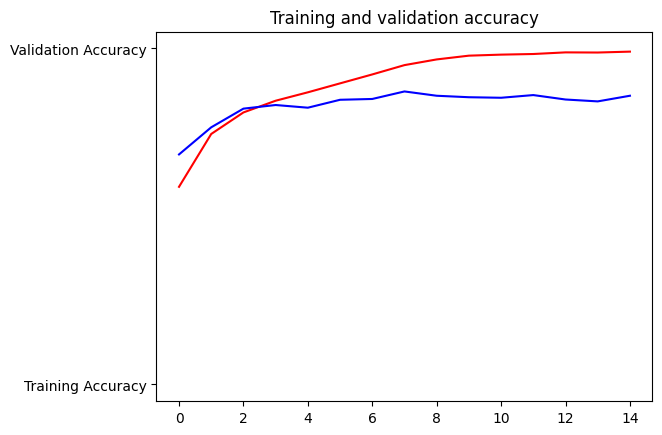

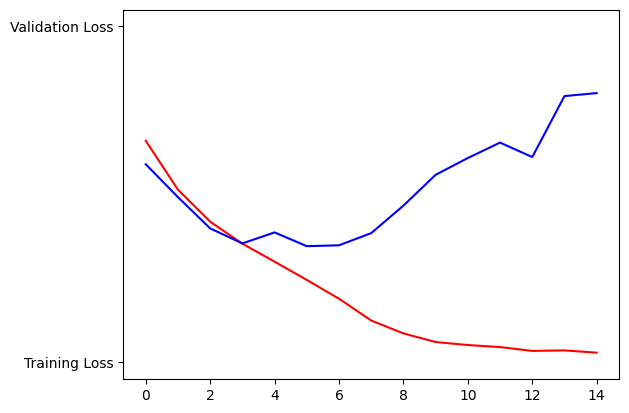

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()


In [ ]:
model.save('catdog.h5')

In [ ]:
from keras.models import load_model

In [17]:
model=load_model('catdog.h5')